# Illustrative example of 1D noise example


In [1]:
# standard libraries
import time
import warnings

# third-party libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.metrics import r2_score
from mfpml.models.gaussian_process import GaussianProcess


# local libraries
from mfbml.methods.mf_rbf_gpr import MFRBFGPR
from mfbml.methods.rbf_kernel import RBF
from mfbml.problems.illutrative_problems import mf_Forrester
from mfbml.metrics.accuracy_metrics import (
    normalized_mae,
    normalized_rmse,
    mean_log_likelihood_value,
)

# ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# fix the seed for reproducibility
seed_number = 1996
np.random.seed(seed_number)

# noise level for this case
noise_add = 0.3
noise_lf_add = 0.3

# samples information
num_hf_samples = 7
num_lf_samples = 70
num_test_samples = 1000
optimizer_restart = 10

## design of experiments for 1D noise example


In [3]:
func = mf_Forrester()

# define sampler
sample_lx = np.linspace(0, 1, num_lf_samples).reshape(-1, 1)
sample_hx = np.linspace(0, 1, num_hf_samples).reshape(-1, 1)
sample_x = {"hf": sample_hx, "lf": sample_lx}

# noise corruption
noise_on_train_hf_response = np.random.normal(
    0, noise_add, size=num_hf_samples
).reshape(-1, 1)
noise_on_train_lf_response = np.random.normal(
    0, noise_lf_add, size=num_lf_samples
).reshape(-1, 1)

noise_on_test_response = np.random.normal(0, noise_add, size=num_test_samples).reshape(
    -1, 1
)


# get responses for high-fidelity model
response_hf = func.hf(sample_hx) + noise_on_train_hf_response

# get responses for three different low-fidelity models
response_lf_1 = func.lf_1(sample_lx) + noise_on_train_lf_response
response_lf_2 = func.lf_2(sample_lx) + noise_on_train_lf_response
response_lf_3 = (
    func.lf_factor(sample_lx, beta_0=1, beta_1=0.1) +
    noise_on_train_lf_response
)


# prepare for dict for training
sample_y_1 = {}
# get response
sample_y_1["hf"] = response_hf
sample_y_1["lf"] = response_lf_1

# lf_2
sample_y_2 = {}
sample_y_2["hf"] = response_hf
sample_y_2["lf"] = response_lf_2

# lf_3
sample_y_3 = {}
sample_y_3["hf"] = response_hf
sample_y_3["lf"] = response_lf_3


# generate test samples
test_x = np.linspace(0, 1, num_test_samples).reshape(-1, 1)
test_hy = func.hf(test_x)
test_lf_1 = func.lf_1(test_x)
test_lf_2 = func.lf_2(test_x)
test_lf_3 = func.lf_factor(test_x, beta_0=1, beta_1=0.1)


# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, num_test_samples).reshape(-1, 1)
test_hy_noisy = func.hf(test_x_noisy) + noise_on_test_response

## hyper-parameters and visualization functions


In [4]:
# hyper-parameter for all models
kernel = RBF(
    theta=np.ones(func.num_dim),
    bounds=[-2, 3],
)

# generate likelihood grid values for all models


def generate_likelihood_grid_values(model):
    model.noise = None
    theta = np.linspace(-2, 3, 100)
    noise = np.linspace(1e-5, 1, 100)
    theta, noise = np.meshgrid(theta, noise)
    # calculate the log_likelihood
    log_likelihood_gpr = np.zeros(theta.shape)
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            list_params = [theta[i, j], noise[i, j]]
            log_likelihood_gpr[i, j] = model._logLikelihood(params=list_params)
    # find the maximum log_likelihood
    min_log_likelihood_gpr = np.min(log_likelihood_gpr)
    print("min_negative_log_likelihood: ", min_log_likelihood_gpr)
    # find the index of the maximum log_likelihood
    idx = np.where(log_likelihood_gpr == min_log_likelihood_gpr)
    best_theta = theta[idx]
    best_noise = noise[idx]
    print("best theta: ", theta[idx])
    print("best noise: ", noise[idx])

    return (
        log_likelihood_gpr,
        theta,
        noise,
        min_log_likelihood_gpr,
        best_theta,
        best_noise,
    )

## GPR model


In [5]:
# define the gpr model
start_time = time.time()
gpr = GaussianProcess(
    design_space=func.design_space,
    kernel=kernel,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
gpr.train(sample_x=sample_x["hf"], sample_y=sample_y_1["hf"])
end_time = time.time()
gpr_time = end_time - start_time

# get the prediction of gpr model
gpr_pred_y, gpr_pred_std = gpr.predict(x_predict=test_x, return_std=True)

# get the trained parameters
theta_learned_gpr = np.log10(gpr.kernel.param)
noise_learned_gpr = gpr.noise
# print information to the screen
print("gpr training time: ", end_time - start_time)
print("gpr learned log theta: ", theta_learned_gpr)
print("gpr learned noise: ", noise_learned_gpr)

gpr training time:  0.1410074234008789
gpr learned log theta:  [3.]
gpr learned noise:  6.125384851352239e-05


In [6]:
# get the likelihood grid values
(
    log_likelihood_gpr,
    theta_plot,
    noise_plot,
    min_log_likelihood_gpr,
    best_theta_gpr,
    best_noise_gpr,
) = generate_likelihood_grid_values(gpr)

min_negative_log_likelihood:  3.5000000000007625
best theta:  [3.]
best noise:  [1.e-05]


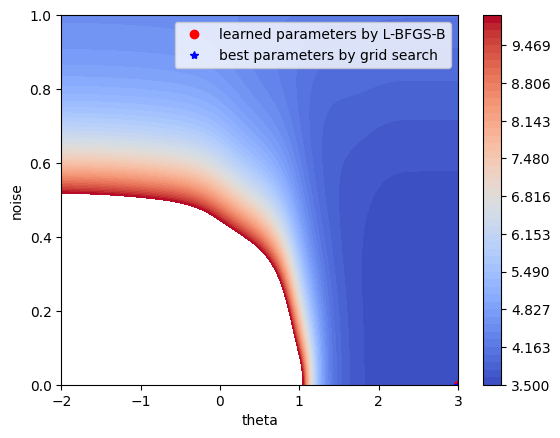

In [7]:
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(
    theta_plot,
    noise_plot,
    log_likelihood_gpr,
    levels=np.linspace(log_likelihood_gpr.min(), 10, 50),
    cmap=cm.coolwarm,
)
ax.plot(
    theta_learned_gpr, noise_learned_gpr, "ro", label="learned parameters by L-BFGS-B"
)
ax.plot(best_theta_gpr, best_noise_gpr, "b*",
        label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
ax.set_xlim(-2, 3)
ax.set_ylim(0, 1)
fig.colorbar(cs)
plt.show()

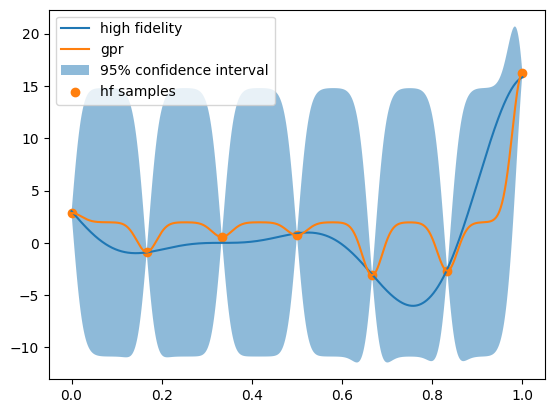

In [8]:
# plot the prediction
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, gpr_pred_y, label="gpr")
ax.fill_between(
    test_x.flatten(),
    (gpr_pred_y - 1.96 * gpr_pred_std).flatten(),
    (gpr_pred_y + 1.96 * gpr_pred_std).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.scatter(sample_x["hf"], sample_y_3["hf"], label="hf samples")
ax.legend()
plt.show()

## train mf-rbf-gpr model on Forrestor la funciton


In [10]:
# for developed methods
start_time = time.time()
mfrbfgp1a = MFRBFGPR(
    design_space=func.design_space,
    kernel=kernel,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
    seed=seed_number,
)
mfrbfgp1a.train(samples=sample_x, responses=sample_y_1)
end_time = time.time()
mfrbfgp1a_time = end_time - start_time

# get the prediction for mfrbfgp1a
mfrbfgp_pred_y_1a, mfrbfgp_pred_std_1a = mfrbfgp1a.predict(
    X=test_x, return_std=True)
pred_ly1a = mfrbfgp1a.predict_lf(X=test_x)

# get the trained parameters
theta_learned_mfrbfgp1a = np.log10(mfrbfgp1a.kernel.param)
noise_learned_mfrbfgp1a = mfrbfgp1a.noise

# print information to the screen
print("mfrbfgp1a training time: ", end_time - start_time)
print("mfrbfgp1a learned log theta: ", theta_learned_mfrbfgp1a)
print("mfrbfgp1a learned noise: ", noise_learned_mfrbfgp1a)

mfrbfgp1a training time:  2.3708951473236084
mfrbfgp1a learned log theta:  [-2.]
mfrbfgp1a learned noise:  0.34892026994109326


In [11]:
# get the likelihood grid values
(
    log_likelihood_mfrbfgp1a,
    _,
    _,
    min_log_likelihood_mfrbfgp1a,
    best_theta_gpr_mfrbfgp1a,
    best_noise_gpr_mfrbfgp1a,
) = generate_likelihood_grid_values(mfrbfgp1a)

min_negative_log_likelihood:  -12.720241253688124
best theta:  [-2.]
best noise:  [0.06061545]


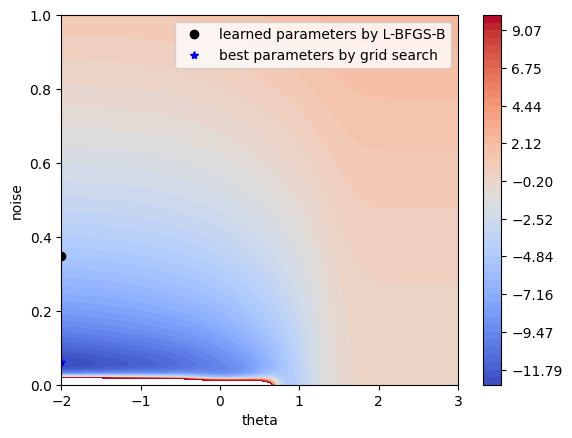

In [12]:
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(
    theta_plot,
    noise_plot,
    log_likelihood_mfrbfgp1a,
    levels=np.linspace(log_likelihood_mfrbfgp1a.min(), 10, 50),
    cmap=cm.coolwarm,
)
ax.plot(
    theta_learned_mfrbfgp1a,
    noise_learned_mfrbfgp1a,
    "ko",
    label="learned parameters by L-BFGS-B",
)
ax.plot(
    best_theta_gpr_mfrbfgp1a,
    best_noise_gpr_mfrbfgp1a,
    "b*",
    label="best parameters by grid search",
)
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
ax.set_xlim(-2, 3)
ax.set_ylim(0, 1)
fig.colorbar(cs)
plt.show()

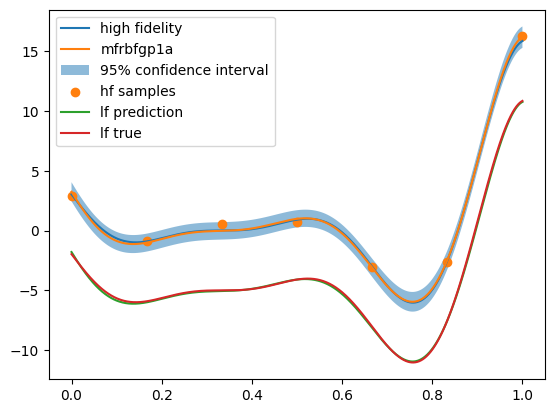

In [13]:
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1a, label="mfrbfgp1a")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1a - 1.96 * mfrbfgp_pred_std_1a).flatten(),
    (mfrbfgp_pred_y_1a + 1.96 * mfrbfgp_pred_std_1a).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.scatter(sample_x["hf"], sample_y_3["hf"], label="hf samples")
# plot lf
ax.plot(test_x, pred_ly1a, label="lf prediction")
ax.plot(test_x, test_lf_1, label="lf true")
ax.legend()
plt.show()

## train mf-rbf-gpr model on Frrestor lb function


In [13]:
start_time = time.time()
mfrbfgp1b = MFRBFGPR(
    design_space=func.design_space,
    noise_prior=None,
    kernel=kernel,
    optimizer_restart=optimizer_restart,
    seed=seed_number,
)
mfrbfgp1b.train(samples=sample_x, responses=sample_y_2)
end_time = time.time()
mfrbfgp1b_time = end_time - start_time

# get the prediction for mfrbfgp1b
mfrbfgp_pred_y_1b, mfrbfgp_pred_std_1b = mfrbfgp1b.predict(
    X=test_x, return_std=True)
# get prediction of low fidelity
pred_ly1b = mfrbfgp1b.predict_lf(X=test_x)
theta_learned_mfrbfgp1b = np.log10(mfrbfgp1b.kernel.param)
noise_learned_mfrbfgp1b = mfrbfgp1b.noise

print("mfrbfgp1b training time: ", end_time - start_time)
print("mfrbfgp1b learned theta: ", theta_learned_mfrbfgp1b)
print("mfrbfgp1b learned noise: ", noise_learned_mfrbfgp1b)

mfrbfgp1b training time:  4.851789474487305
mfrbfgp1b learned theta:  [-0.03183876]
mfrbfgp1b learned noise:  0.2723049799207207


In [14]:
# get the likelihood grid values
(
    log_likelihood_mfrbfgp1b,
    _,
    _,
    min_log_likelihood_mfrbfgp1b,
    best_theta_gpr_mfrbfgp1b,
    best_noise_gpr_mfrbfgp1b,
) = generate_likelihood_grid_values(mfrbfgp1b)

min_negative_log_likelihood:  -6.912629483058589
best theta:  [-0.03030303]
best noise:  [0.04041364]


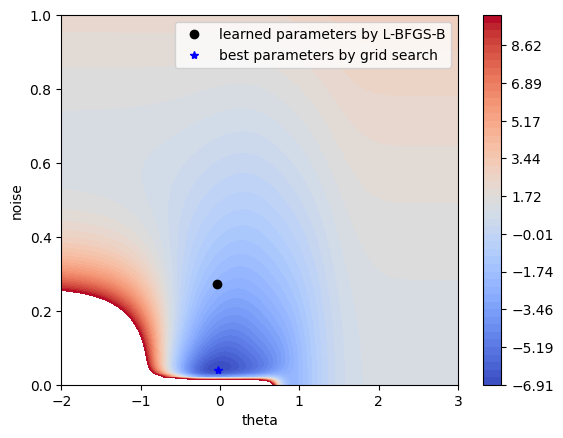

In [15]:
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(
    theta_plot,
    noise_plot,
    log_likelihood_mfrbfgp1b,
    levels=np.linspace(log_likelihood_mfrbfgp1b.min(), 10, 50),
    cmap=cm.coolwarm,
)
ax.plot(
    theta_learned_mfrbfgp1b,
    noise_learned_mfrbfgp1b,
    "ko",
    label="learned parameters by L-BFGS-B",
)
ax.plot(
    best_theta_gpr_mfrbfgp1b,
    best_noise_gpr_mfrbfgp1b,
    "b*",
    label="best parameters by grid search",
)
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
ax.set_xlim(-2, 3)
ax.set_ylim(0, 1)
fig.colorbar(cs)
plt.show()

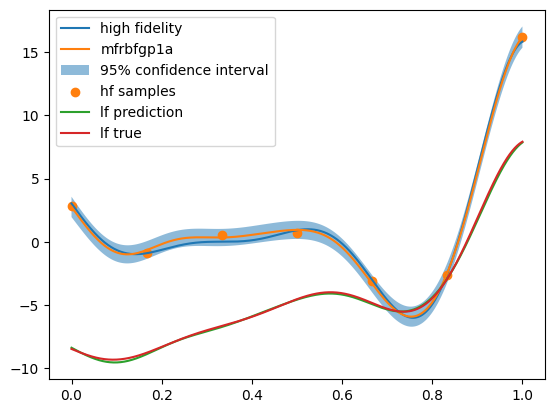

In [16]:
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1b, label="mfrbfgp1a")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1b - 1.96 * mfrbfgp_pred_std_1b).flatten(),
    (mfrbfgp_pred_y_1b + 1.96 * mfrbfgp_pred_std_1b).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.scatter(sample_x["hf"], sample_y_3["hf"], label="hf samples")
# plot lf
ax.plot(test_x, pred_ly1b, label="lf prediction")
ax.plot(test_x, test_lf_2, label="lf true")
ax.legend()
plt.show()

## train mf-rbf-gpr on Forrester lc function


In [17]:
start_time = time.time()
mfrbfgp1c = MFRBFGPR(
    design_space=func.design_space,
    noise_prior=None,
    kernel=kernel,
    optimizer_restart=optimizer_restart,
    seed=seed_number,
)
mfrbfgp1c.train(samples=sample_x, responses=sample_y_3)
end_time = time.time()
mfrbfgp1c_time = end_time - start_time

# get the prediction for mfrbfgp1c
mfrbfgp_pred_y_1c, mfrbfgp_pred_std_1c = mfrbfgp1c.predict(
    X=test_x, return_std=True)
# get prediction of low fidelity
pred_ly1c = mfrbfgp1c.predict_lf(X=test_x)

# get the learned parameters
theta_learned_mfrbfgp1c = np.log10(mfrbfgp1c.kernel.param)
noise_learned_mfrbfgp1c = mfrbfgp1c.noise

# print information to the screen
print("mfrbfgp1c time: ", end_time - start_time)
print("learned theta: ", theta_learned_mfrbfgp1c)
print("learned noise: ", noise_learned_mfrbfgp1c)

mfrbfgp1c time:  2.058976650238037
learned theta:  [1.41995713]
learned noise:  6.125384851352239e-05


In [18]:
# get the likelihood grid values
(
    log_likelihood_mfrbfgp1c,
    _,
    _,
    min_log_likelihood_mfrbfgp1c,
    best_theta_gpr_mfrbfgp1c,
    best_noise_gpr_mfrbfgp1c,
) = generate_likelihood_grid_values(mfrbfgp1c)

min_negative_log_likelihood:  2.4245059488738234
best theta:  [1.43434343]
best noise:  [1.e-05]


In [19]:
#  generate the meshgrid for the parameters theta and noise
mfrbfgp1c.noise = None
theta = np.linspace(-2, 3, 100)
noise = np.linspace(0.01, 0.5, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood1c = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood1c[i, j] = mfrbfgp1c._logLikelihood(params=list_params)

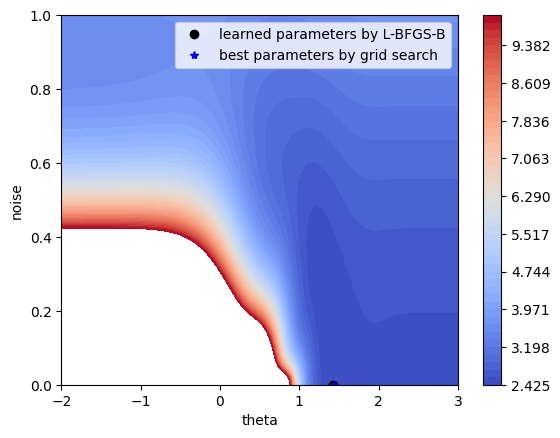

In [20]:
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(
    theta_plot,
    noise_plot,
    log_likelihood_mfrbfgp1c,
    levels=np.linspace(log_likelihood_mfrbfgp1c.min(), 10, 50),
    cmap=cm.coolwarm,
)
ax.plot(
    theta_learned_mfrbfgp1c,
    noise_learned_mfrbfgp1c,
    "ko",
    label="learned parameters by L-BFGS-B",
)
ax.plot(
    best_theta_gpr_mfrbfgp1c,
    best_noise_gpr_mfrbfgp1c,
    "b*",
    label="best parameters by grid search",
)
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
ax.set_xlim(-2, 3)
ax.set_ylim(0, 1)
fig.colorbar(cs)
plt.show()

## plot predictions on log marginal likelihood values


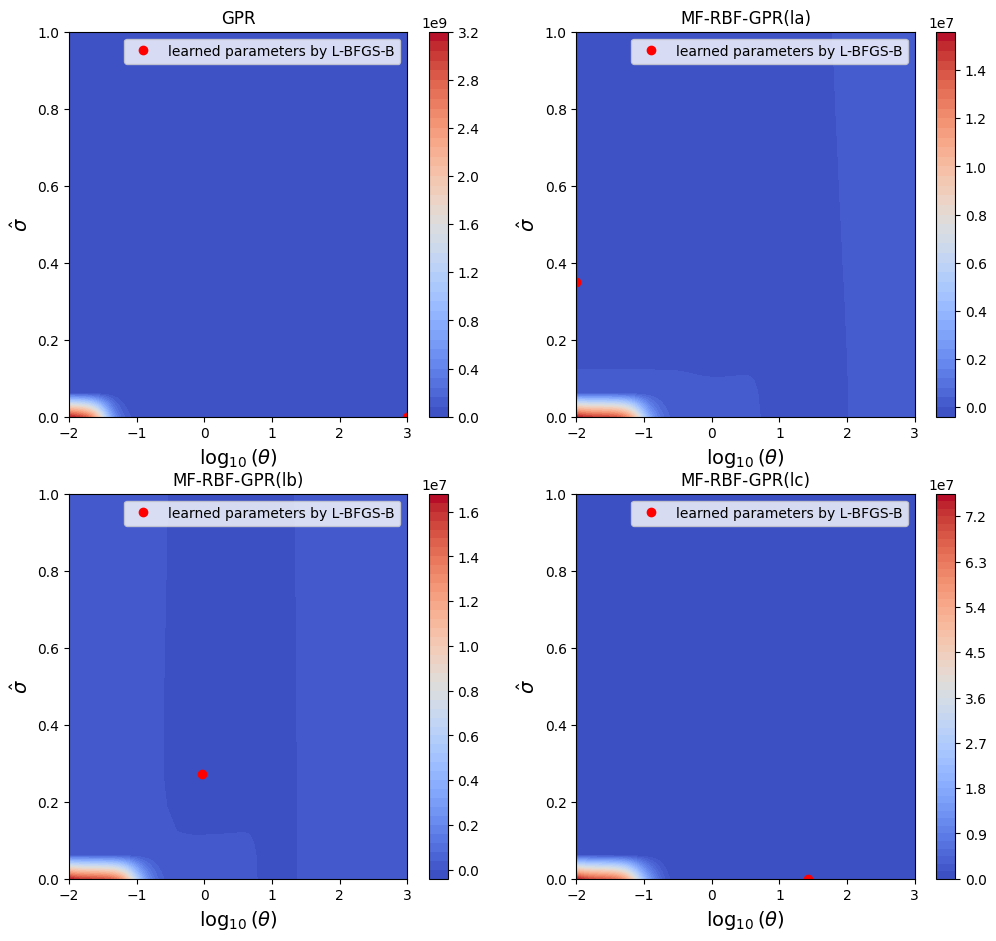

In [21]:
# plot the land scape of  log_likelihood function for all three functions and gpr method

fig, ax = plt.subplots(2, 2, figsize=(12, 11))
# plot the log_likelihood
cs = ax[0, 0].contourf(
    theta_plot, noise_plot * gpr.y_std, log_likelihood_gpr, levels=50, cmap=cm.coolwarm
)
ax[0, 0].plot(
    theta_learned_gpr, noise_learned_gpr, "ro", label="learned parameters by L-BFGS-B"
)
ax[0, 0].legend(loc="best")
ax[0, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 0].set_ylim(0, 1)
ax[0, 0].set_title("GPR")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[0, 1].contourf(
    theta_plot,
    noise_plot * mfrbfgp1a.yh_std,
    log_likelihood_mfrbfgp1a,
    levels=50,
    cmap=cm.coolwarm,
)
ax[0, 1].plot(
    theta_learned_mfrbfgp1a,
    noise_learned_mfrbfgp1a,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[0, 1].legend(loc="best")
ax[0, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 1].set_title("MF-RBF-GPR(la)")
ax[0, 1].set_ylim(0, 1)
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 0].contourf(
    theta_plot,
    noise_plot * mfrbfgp1b.yh_std,
    log_likelihood_mfrbfgp1b,
    levels=50,
    cmap=cm.coolwarm,
)
ax[1, 0].plot(
    theta_learned_mfrbfgp1b,
    noise_learned_mfrbfgp1b,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 0].legend(loc="best")
ax[1, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 0].set_title("MF-RBF-GPR(lb)")
ax[1, 0].set_ylim(0, 1)
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 1].contourf(
    theta_plot,
    noise_plot * mfrbfgp1c.yh_std,
    log_likelihood_mfrbfgp1c,
    levels=50,
    cmap=cm.coolwarm,
)
ax[1, 1].plot(
    theta_learned_mfrbfgp1c,
    noise_learned_mfrbfgp1c,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 1].legend(loc="best")
ax[1, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 1].set_ylim(0, 1)
ax[1, 1].set_title("MF-RBF-GPR(lc)")
fig.colorbar(cs)
plt.savefig("neg_log_likelihood_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison.svg", dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

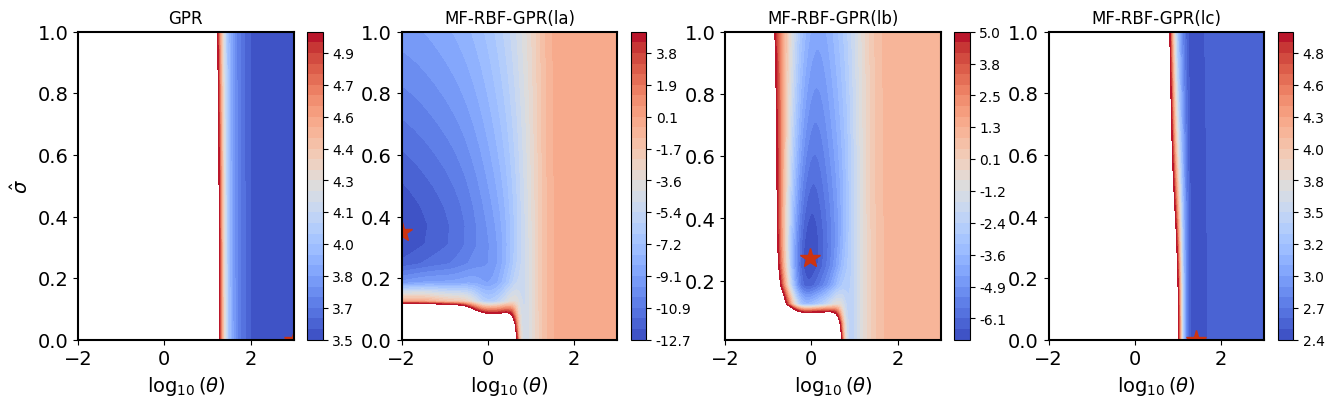

In [78]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
# plot the log_likelihood
cs = ax[0].contourf(
    theta_plot,
    noise_plot * gpr.y_std,
    log_likelihood_gpr,
    levels=np.linspace(log_likelihood_gpr.min(), 5, 30),
    cmap=cm.coolwarm,
)
ax[0].plot(theta_learned_gpr, noise_learned_gpr,
           "*", color="#CC3311", markersize=15)
ax[0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0].set_ylim(0, 1)
ax[0].set_title("GPR")
cbar = fig.colorbar(cs)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))

# plot the log_likelihood
cs = ax[1].contourf(
    theta_plot,
    noise_plot * mfrbfgp1a.yh_std,
    log_likelihood_mfrbfgp1a,
    levels=np.linspace(log_likelihood_mfrbfgp1a.min(), 5, 30),
    cmap=cm.coolwarm,
)
ax[1].plot(
    theta_learned_mfrbfgp1a,
    noise_learned_mfrbfgp1a,
    "*",
    color="#CC3311",
    markersize=15,
)
ax[1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1].set_title("MF-RBF-GPR(la)")
ax[1].set_ylim(0, 1)
cbar = fig.colorbar(cs)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
# plot the log_likelihood
cs = ax[2].contourf(
    theta_plot,
    noise_plot * mfrbfgp1b.yh_std,
    log_likelihood_mfrbfgp1b,
    levels=np.linspace(log_likelihood_mfrbfgp1b.min(), 5, 30),
    cmap=cm.coolwarm,
)
ax[2].plot(
    theta_learned_mfrbfgp1b,
    noise_learned_mfrbfgp1b,
    "*",
    color="#CC3311",
    markersize=15,
)

ax[2].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[2].set_title("MF-RBF-GPR(lb)")
ax[2].set_ylim(0.01, 1)
cbar = fig.colorbar(cs)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
# plot the log_likelihood
cs = ax[3].contourf(
    theta_plot,
    noise_plot * mfrbfgp1c.yh_std,
    log_likelihood_mfrbfgp1c,
    levels=np.linspace(log_likelihood_mfrbfgp1c.min(), 5, 30),
    cmap=cm.coolwarm,
)
ax[3].plot(
    theta_learned_mfrbfgp1c,
    noise_learned_mfrbfgp1c,
    "*",
    color="#CC3311",
    markersize=15,
)
ax[3].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[3].set_ylim(0, 1)
ax[3].set_title("MF-RBF-GPR(lc)")
cbar = fig.colorbar(cs)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))

# set the font size of axis
for i in range(4):
    ax[i].tick_params(axis="both", which="major", labelsize=font_size)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)

plt.savefig("neg_log_likelihood_comparison_zoom_in.png",
            dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison_zoom_in.svg",
            dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison_zoom_in.pdf",
            dpi=300, bbox_inches="tight")
plt.show()

In [70]:
# output the learned parameters
print("gpr theta: ", gpr.kernel.param)
print("gpr beta: ", gpr.beta)
print("gpr noise: ", noise_learned_gpr)
print("mfrbfgp1a theta: ", mfrbfgp1a.kernel.param)
print("mfrbfgp1a beta: ", mfrbfgp1a.beta)
print("mfrbfgp1a noise: ", noise_learned_mfrbfgp1a)
print("mfrbfgp1b theta: ", mfrbfgp1b.kernel.param)
print("mfrbfgp1b beta: ", mfrbfgp1b.beta)
print("mfrbfgp1b noise: ", noise_learned_mfrbfgp1b)
print("mfrbfgp1c theta: ", mfrbfgp1c.kernel.param)
print("mfrbfgp1c beta: ", mfrbfgp1c.beta)
print("mfrbfgp1c noise: ", noise_learned_mfrbfgp1c)

gpr theta:  [26.30008337]
gpr beta:  [[3.05025846e-13]]
gpr noise:  6.125384851352239e-05
mfrbfgp1a theta:  [26.30008337]
mfrbfgp1a beta:  [[0.81250344]
 [1.01762163]]
mfrbfgp1a noise:  0.34892026994109326
mfrbfgp1b theta:  [26.30008337]
mfrbfgp1b beta:  [[2.01311037]
 [1.93857306]]
mfrbfgp1b noise:  0.2723049799207207
mfrbfgp1c theta:  [26.30008337]
mfrbfgp1c beta:  [[0.86232408]
 [1.39850032]]
mfrbfgp1c noise:  6.125384851352239e-05


#


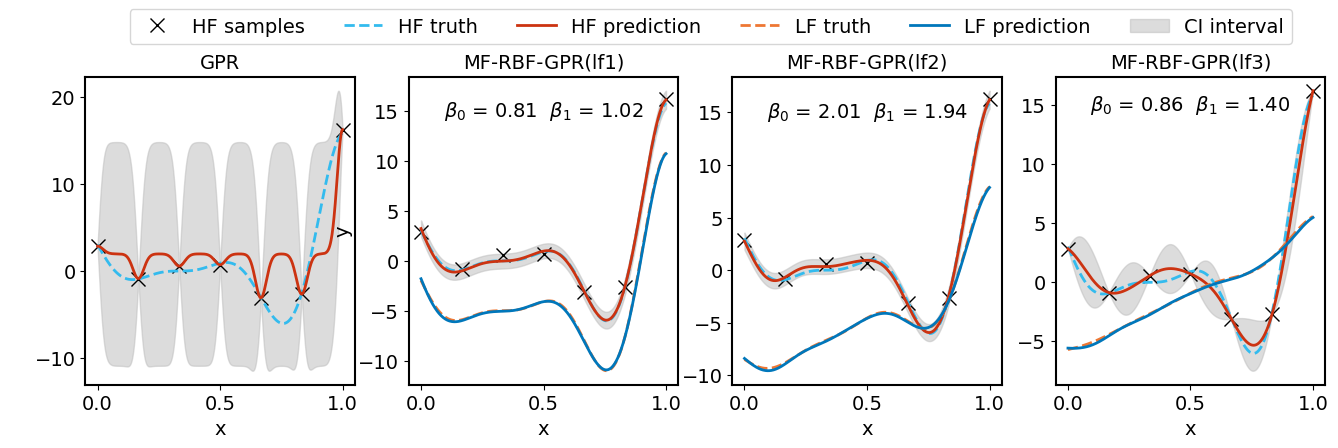

In [77]:
# plot results in 2x2 grid
font_size = 14
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(
    sample_x["hf"],
    sample_y_1["hf"],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[0].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[0].plot(test_x, gpr_pred_y, "-", color="#CC3311",
           linewidth=2, label="HF prediction")

ax[0].fill_between(
    test_x.flatten(),
    (gpr_pred_y - 1.96 * gpr_pred_std).flatten(),
    (gpr_pred_y + 1.96 * gpr_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].set_title("GPR", fontsize=font_size)
ax[0].set_ylabel(" ", fontsize=font_size)
ax[0].set_xlabel("x", fontsize=font_size)
# for lf 1
ax[1].plot(
    sample_x["hf"],
    sample_y_1["hf"],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[1].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[1].plot(
    test_x, mfrbfgp_pred_y_1a, "-", color="#CC3311", linewidth=2, label="HF prediction"
)
ax[1].plot(test_x, test_lf_1, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[1].plot(test_x, pred_ly1a, "-", color="#0077BB",
           linewidth=2, label="LF prediction")

ax[1].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1a - 2 * mfrbfgp_pred_std_1a).flatten(),
    (mfrbfgp_pred_y_1a + 2 * mfrbfgp_pred_std_1a).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1].set_title("MF-RBF-GPR(lf1)", fontsize=font_size)
ax[1].set_ylabel("y", fontsize=font_size)
ax[1].set_xlabel("x", fontsize=font_size)

# for co-kriging
ax[2].plot(
    sample_x["hf"],
    sample_y_2["hf"],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[2].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[2].plot(
    test_x, mfrbfgp_pred_y_1b, "-", color="#CC3311", linewidth=2, label="HF prediction"
)
ax[2].plot(test_x, test_lf_2, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[2].plot(test_x, pred_ly1b, "-", color="#0077BB",
           linewidth=2, label="LF prediction")

ax[2].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1b - 2 * mfrbfgp_pred_std_1b).flatten(),
    (mfrbfgp_pred_y_1b + 2 * mfrbfgp_pred_std_1b).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[2].set_title("MF-RBF-GPR(lf2)", fontsize=font_size)
ax[2].set_ylabel(" ", fontsize=font_size)
ax[2].set_xlabel("x", fontsize=font_size)

# for scaled kriging
ax[3].plot(
    sample_x["hf"],
    sample_y_3["hf"],
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[3].plot(test_x, test_hy, "--", color="#33BBEE",
           linewidth=2, label="HF truth")
ax[3].plot(
    test_x,
    mfrbfgp_pred_y_1c,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
ax[3].plot(test_x, test_lf_3, "--", color="#EE7733",
           linewidth=2, label="LF truth")
ax[3].plot(test_x, pred_ly1c, "-", color="#0077BB",
           linewidth=2, label="LF prediction")

ax[3].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1c - 2 * mfrbfgp_pred_std_1c).flatten(),
    (mfrbfgp_pred_y_1c + 2 * mfrbfgp_pred_std_1c).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# write text on the plot of beta0= 0.5  and beta0= 0.5 on the middle top of the plot
ax[1].text(
    0.5,
    15.0,
    r"$\beta_0$ = {:.2f}  $\beta_1$ = {:.2f}".format(
        mfrbfgp1a.beta[0, 0], mfrbfgp1a.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
ax[2].text(
    0.5,
    15.0,
    r"$\beta_0$ = {:.2f}  $\beta_1$ = {:.2f}".format(
        mfrbfgp1b.beta[0, 0], mfrbfgp1b.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)
# two numbers on the middle top of the plot for mf-rbf-kriging on two lines
ax[3].text(
    0.5,
    15.0,
    r"$\beta_0$ = {:.2f}  $\beta_1$ = {:.2f}".format(
        mfrbfgp1c.beta[0, 0], mfrbfgp1c.beta[1, 0]
    ),
    fontsize=font_size,
    ha="center",
    va="center",
    backgroundcolor="white",
)

ax[3].set_title("MF-RBF-GPR(lf3)", fontsize=font_size)
ax[3].set_ylabel(" ", fontsize=font_size)
ax[3].set_xlabel("x", fontsize=font_size)


plt.legend(loc="upper center", bbox_to_anchor=(-1.28, 1.25),
           ncol=6, fontsize=14)
# set the font size of axis
for i in range(4):
    ax[i].tick_params(axis="both", which="major", labelsize=font_size)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)
plt.savefig("prediction_comparison.pdf", bbox_inches="tight", dpi=300)
plt.savefig("prediction_comparison.png", bbox_inches="tight", dpi=300)
plt.savefig("prediction_comparison.svg", bbox_inches="tight", dpi=300)
plt.show()

In [29]:
# calculate the rmse, mae, r2 score and nll for all three functions
# gpr
import pandas as pd

gpr_rmse = normalized_rmse(test_hy, gpr_pred_y)
gpr_mae = normalized_mae(test_hy, gpr_pred_y)
gpr_r2 = r2_score(test_hy, gpr_pred_y)
gpr_nll = mean_log_likelihood_value(test_hy_noisy, gpr_pred_y, gpr_pred_std)

# mfrbfgp1a
mfrbfgp1a_rmse = normalized_rmse(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_mae = normalized_mae(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_r2 = r2_score(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_nll = mean_log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y_1a, mfrbfgp_pred_std_1a
)

# mfrbfgp1b
mfrbfgp1b_rmse = normalized_rmse(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_mae = normalized_mae(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_r2 = r2_score(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_nll = mean_log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y_1b, mfrbfgp_pred_std_1b
)


# mfrbfgp1c
mfrbfgp1c_rmse = normalized_rmse(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_mae = normalized_mae(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_r2 = r2_score(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_nll = mean_log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y_1c, mfrbfgp_pred_std_1c
)


# save all those results to pandas dataframe
# create a dictionary
data = {
    "nrmse": [gpr_rmse, mfrbfgp1a_rmse, mfrbfgp1b_rmse, mfrbfgp1c_rmse],
    "nmae": [gpr_mae, mfrbfgp1a_mae, mfrbfgp1b_mae, mfrbfgp1c_mae],
    "r2": [gpr_r2, mfrbfgp1a_r2, mfrbfgp1b_r2, mfrbfgp1c_r2],
    "nll": [gpr_nll, mfrbfgp1a_nll, mfrbfgp1b_nll, mfrbfgp1c_nll],
    "cpu_time": [gpr_time, mfrbfgp1a_time, mfrbfgp1b_time, mfrbfgp1c_time],
    "noise": [
        noise_learned_gpr,
        noise_learned_mfrbfgp1a,
        noise_learned_mfrbfgp1b,
        noise_learned_mfrbfgp1c,
    ],
    "beta": [gpr.beta, mfrbfgp1a.beta, mfrbfgp1b.beta, mfrbfgp1c.beta],
}
# create a dataframe
df = pd.DataFrame(data, index=["gpr", "mfrbfgp1a", "mfrbfgp1b", "mfrbfgp1c"])
print(df)

# save the dataframe to csv file
df.to_csv("comparison.csv")

              nrmse      nmae        r2           nll  cpu_time     noise  \
gpr        1.321508  3.533285  0.411193 -43593.027730  0.217932  0.000061   
mfrbfgp1a  0.041459  0.124698  0.999420     -0.319935  2.306995  0.348920   
mfrbfgp1b  0.108723  0.199185  0.996015     -0.588092  4.851789  0.272305   
mfrbfgp1c  0.278208  0.646470  0.973904 -44416.445213  2.058977  0.000061   

                                                   beta  
gpr                          [[3.0502584591275685e-13]]  
mfrbfgp1a  [[0.8125034440562792], [1.0176216314037339]]  
mfrbfgp1b   [[2.013110369165766], [1.9385730607521585]]  
mfrbfgp1c  [[0.8623240820065362], [1.3985003209894327]]  
